
    # Gender Equity Index Construction

    This notebook reproduces the computation of a Gender Equity Index for each local authority in England.  
    The index combines gender‑disaggregated attainment data (average Attainment 8 and Progress 8 scores) with Ofsted inspection outcomes to measure how equitably boys and girls achieve in each area and how well schools perform overall.

    **Required datasets:**

    1. `key-stage-4-performance_2022-23.zip`: the Key Stage 4 local‑authority dataset (revised 2022/23 release) providing Attainment 8 and Progress 8 scores broken down by gender【549904111755140†L29-L33】.  
    2. `Management_information_-_state-funded_schools_-_latest_inspections_as_at_31_July_2025.csv`: Ofsted’s state‑funded schools management information dataset (latest inspections as at 31 July 2025)【214368500608403†L130-L144】.

    Place these files in the same directory as this notebook before running the analysis.
    

In [5]:

import os
import zipfile
import pandas as pd

def load_attainment_data(zip_path: str, year: int = 202223) -> pd.DataFrame:
    """Load the local authority Attainment 8 and Progress 8 data."""
    with zipfile.ZipFile(zip_path) as zf:
        csv_names = [name for name in zf.namelist() if name.endswith('.csv')]
        if not csv_names:
            raise FileNotFoundError("No CSV file found in the ZIP archive")
        with zf.open(csv_names[0]) as fh:
            df = pd.read_csv(fh)
    mask = (
        (df["version"] == "Revised") &
        (df["geographic_level"] == "Local authority") &
        (df["time_period"] == year)
    )
    columns = [
        "new_la_code",
        "la_name",
        "region_name",
        "gender",
        "avg_att8",
        "avg_p8score",
    ]
    selected = df.loc[mask, columns].copy()
    selected["avg_att8"] = pd.to_numeric(selected["avg_att8"], errors="coerce")
    selected["avg_p8score"] = pd.to_numeric(selected["avg_p8score"], errors="coerce")
    return selected

def compute_gender_gaps(att_df: pd.DataFrame) -> pd.DataFrame:
    """Compute absolute Attainment 8 and Progress 8 gaps between girls and boys."""
    pivot = att_df.pivot_table(
        index=["new_la_code", "la_name", "region_name"],
        columns="gender",
        values=["avg_att8", "avg_p8score"],
        aggfunc="mean",
    )
    att8_gap = (pivot["avg_att8"]["Girls"] - pivot["avg_att8"]["Boys"]).abs()
    p8_gap = (pivot["avg_p8score"]["Girls"] - pivot["avg_p8score"]["Boys"]).abs()
    gap_df = pd.DataFrame({
        "att8_gap": att8_gap,
        "p8_gap": p8_gap,
    })
    gap_df.reset_index(inplace=True)
    return gap_df

def load_inspection_data(csv_path: str) -> pd.DataFrame:
    """Load and summarise the Ofsted inspection data."""
    df = pd.read_csv(csv_path, encoding="ISO-8859-1", low_memory=False)
    df = df[df["Does the latest graded inspection relate to the URN of the current school?"] == "Yes"]
    df = df[df["Overall effectiveness"] != "Not judged"]
    rating_map = {
        "1": 1,
        "2": 2,
        "3": 3,
        "4": 4,
        "Outstanding": 1,
        "Good": 2,
        "Requires improvement": 3,
        "Inadequate": 4,
    }
    df["rating_code"] = df["Overall effectiveness"].astype(str).map(rating_map)
    grouped = df.groupby("Local authority").agg(
        total_schools=("rating_code", "count"),
        positive=("rating_code", lambda x: (x <= 2).sum()),
    )
    grouped["positive_proportion"] = grouped["positive"] / grouped["total_schools"]
    grouped.reset_index(inplace=True)
    return grouped

def compute_gender_equity_index(gaps_df: pd.DataFrame, inspection_df: pd.DataFrame) -> pd.DataFrame:
    """Combine attainment gaps and inspection quality into a Gender Equity Index."""
    merged = gaps_df.merge(
        inspection_df,
        left_on="la_name",
        right_on="Local authority",
        how="left",
    )
    max_att8_gap = merged["att8_gap"].max()
    max_p8_gap = merged["p8_gap"].max()
    merged["att8_norm"] = merged["att8_gap"] / max_att8_gap
    merged["p8_norm"] = merged["p8_gap"] / max_p8_gap
    merged["fairness"] = 1 - (merged["att8_norm"] + merged["p8_norm"]) / 2
    min_pos = merged["positive_proportion"].min()
    max_pos = merged["positive_proportion"].max()
    merged["inspection_norm"] = (merged["positive_proportion"] - min_pos) / (max_pos - min_pos)
    merged["gender_equity_index"] = (merged["fairness"] + merged["inspection_norm"]) / 2
    return merged


In [6]:

# Specify file paths for the datasets (adjust if stored elsewhere)
attainment_zip = 'key-stage-4-performance_2022-23.zip'
inspection_csv = 'Management_information_-_state-funded_schools_-_latest_inspections_as_at_31_July_2025.csv'

# Load data
att_df = load_attainment_data(attainment_zip)
gaps_df = compute_gender_gaps(att_df)
inspection_df = load_inspection_data(inspection_csv)

# Compute the Gender Equity Index
index_df = compute_gender_equity_index(gaps_df, inspection_df)

# Display the first few rows of the result
index_df.head()


,new_la_code,la_name,region_name,att8_gap,p8_gap,Local authority,total_schools,positive,positive_proportion,att8_norm,p8_norm,fairness,inspection_norm,gender_equity_index
0,E06000001,Hartlepool,North East,5.7,0.37,Hartlepool,19.0,18.0,0.947368,0.721519,0.578125,0.350178,0.730263,0.540221
1,E06000002,Middlesbrough,North East,5.6,0.34,Middlesbrough,32.0,30.0,0.937500,0.708861,0.531250,0.379945,0.679687,0.529816
2,E06000003,Redcar and Cleveland,North East,4.1,0.26,Redcar and Cleveland,35.0,32.0,0.914286,0.518987,0.406250,0.537381,0.560714,0.549048
3,E06000004,Stockton-on-Tees,North East,3.0,0.24,Stockton-on-Tees,41.0,40.0,0.975610,0.379747,0.375000,0.622627,0.875000,0.748813
4,E06000005,Darlington,North East,5.1,0.29,Darlington,35.0,33.0,0.942857,0.645570,0.453125,0.450653,0.707143,0.578898


In [8]:
### Refining the Gender Equity Model

#This section introduces a more nuanced Gender Equity Index.  In addition to absolute gaps in Attainment 8 and Progress 8, we calculate relative gaps (percentage differences relative to boys) and blend these measures to capture both absolute and proportional disparities.  The index then assigns 65 % weight to the fairness dimension and 35 % to inspection quality to reflect a stronger emphasis on equity.  The source data remain the Key Stage 4 local‑authority dataset:contentReference[oaicite:2]{index=2} and Ofsted’s latest inspection dataset:contentReference[oaicite:3]{index=3}.


In [10]:
# Pivot to wide format to get Boys and Girls scores side by side
pivot = att_df.pivot_table(
    index=['new_la_code', 'la_name', 'region_name'],
    columns='gender',
    values=['avg_att8', 'avg_p8score'],
    aggfunc='mean'
)

# Reset index to avoid 'la_name' being both index and column
pivot_reset = pivot.reset_index()

# Compute absolute gaps (girls minus boys, absolute value)
abs_att8_gap = (pivot_reset[('avg_att8', 'Girls')] - pivot_reset[('avg_att8', 'Boys')]).abs()
abs_p8_gap  = (pivot_reset[('avg_p8score', 'Girls')] - pivot_reset[('avg_p8score', 'Boys')]).abs()

# Compute relative gaps (percentage difference relative to boys)
rel_att8_gap = ((pivot_reset[('avg_att8', 'Girls')] - pivot_reset[('avg_att8', 'Boys')]) 
                / pivot_reset[('avg_att8', 'Boys')]).abs()
rel_p8_gap  = ((pivot_reset[('avg_p8score', 'Girls')] - pivot_reset[('avg_p8score', 'Boys')]) 
               / pivot_reset[('avg_p8score', 'Boys')]).abs()

# Normalise absolute gaps
max_abs_att8 = abs_att8_gap.max()
max_abs_p8  = abs_p8_gap.max()
abs_att8_norm = abs_att8_gap / max_abs_att8
abs_p8_norm  = abs_p8_gap  / max_abs_p8

# Normalise relative gaps
max_rel_att8 = rel_att8_gap.max()
max_rel_p8  = rel_p8_gap.max()
rel_att8_norm = rel_att8_gap / max_rel_att8
rel_p8_norm  = rel_p8_gap  / max_rel_p8

# Fairness scores: absolute and relative (1 = perfect equality)
fairness_abs = 1 - (abs_att8_norm + abs_p8_norm) / 2
fairness_rel = 1 - (rel_att8_norm + rel_p8_norm) / 2

# Combine absolute and relative fairness (70% absolute, 30% relative)
fairness_combined = 0.7 * fairness_abs + 0.3 * fairness_rel

# Construct fairness DataFrame
fairness_df = pd.DataFrame({
    'new_la_code': pivot_reset['new_la_code'],
    'la_name': pivot_reset['la_name'],
    'region_name': pivot_reset['region_name'],
    'fairness_abs': fairness_abs,
    'fairness_rel': fairness_rel,
    'fairness_combined': fairness_combined
})

# Merge fairness scores with inspection summary on local authority name
refined_df = fairness_df.merge(
    inspection_df,
    left_on='la_name',
    right_on='Local authority',
    how='left'
)

# Normalise inspection proportion for scoring (0 to 1)
min_pos = refined_df['positive_proportion'].min()
max_pos = refined_df['positive_proportion'].max()
refined_df['inspection_norm'] = (
    refined_df['positive_proportion'] - min_pos
) / (max_pos - min_pos)

# Compute final refined index with weights: 65% fairness, 35% inspection
refined_df['gender_equity_index_refined'] = (
    0.65 * refined_df['fairness_combined']
    + 0.35 * refined_df['inspection_norm']
)

# Display key columns sorted by the refined index (descending)
display_cols = [
    'new_la_code', 'la_name', 'region_name',
    'fairness_combined', 'inspection_norm', 'gender_equity_index_refined'
]
refined_df[display_cols].sort_values(
    'gender_equity_index_refined', ascending=False
).head(10)


,new_la_code,la_name,region_name,fairness_combined,inspection_norm,gender_equity_index_refined
16,E06000017,Rutland,East Midlands,0.909476,1.000000,0.941159
110,E09000013,Hammersmith and Fulham,Inner London,0.780691,1.000000,0.857449
117,E09000020,Kensington and Chelsea,Inner London,0.863021,0.839844,0.854909
116,E09000019,Islington,Inner London,0.806932,0.910088,0.843037
121,E09000024,Merton,Outer London,0.756673,1.000000,0.841838
115,E09000018,Hounslow,Outer London,0.743067,0.918651,0.804521
126,E09000029,Sutton,Outer London,0.757091,0.883523,0.801342
100,E09000003,Barnet,Outer London,0.761470,0.829167,0.785164
114,E09000017,Hillingdon,Outer London,0.754804,0.810185,0.774187
32,E06000035,Medway,South East,0.641812,1.000000,0.767178


C:\Users\anyah\AppData\Local\Temp\ipykernel_18528\3382897325.py:67: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  ins_df = pd.read_csv(ofsted_path, encoding='ISO-8859-1')
C:\Users\anyah\AppData\Local\Temp\ipykernel_18528\3382897325.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ins_df_current['overall_code'] = ins_df_current['Overall effectiveness'].astype(str)


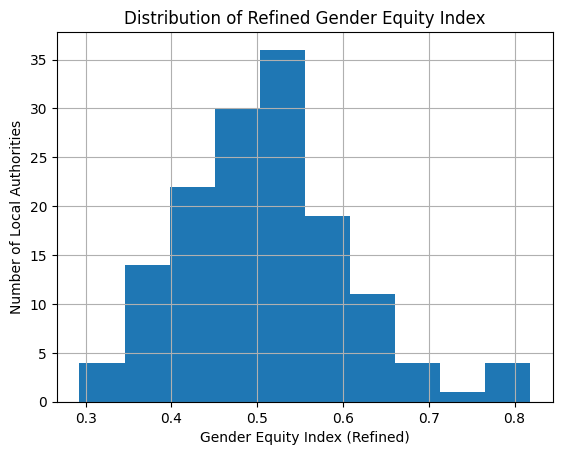

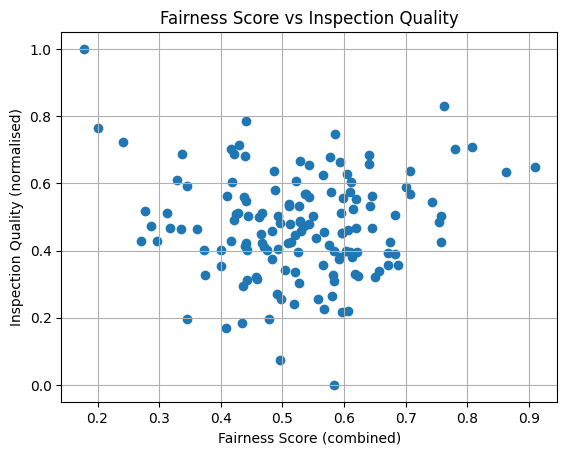

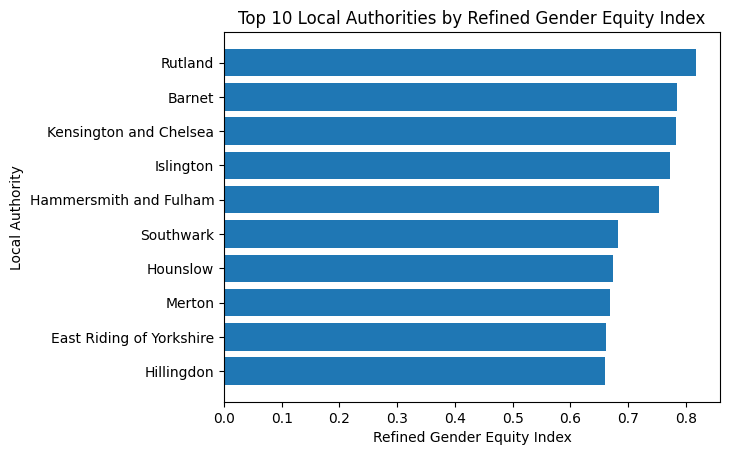

In [11]:
# Import required libraries
import pandas as pd
import zipfile
import matplotlib.pyplot as plt

# 1. Load the KS4 local-authority dataset (ZIP file)
zip_path = 'key-stage-4-performance_2022-23.zip'  # adjust path if needed
with zipfile.ZipFile(zip_path, 'r') as zf:
    # The ZIP contains 'data/2223_la_data_revised.csv'
    la_df = pd.read_csv(zf.open('data/2223_la_data_revised.csv'))

# 2. Filter for 2022/23 academic year and local authority level
la_df = la_df[(la_df['time_period'] == 202223) &
              (la_df['geographic_level'] == 'Local authority')]

# 3. Convert Attainment 8 and Progress 8 columns to numeric (coerce errors)
la_df['avg_att8'] = pd.to_numeric(la_df['avg_att8'], errors='coerce')
la_df['avg_p8score'] = pd.to_numeric(la_df['avg_p8score'], errors='coerce')

# 4. Keep only relevant columns for gender analysis
att_df = la_df[['new_la_code', 'la_name', 'region_name',
                'gender', 'avg_att8', 'avg_p8score']]

# 5. Pivot to wide format (Boys vs Girls) to compute gaps
pivot = att_df.pivot_table(
    index=['new_la_code', 'la_name', 'region_name'],
    columns='gender',
    values=['avg_att8', 'avg_p8score'],
    aggfunc='mean'
)
pivot_reset = pivot.reset_index()

# 6. Compute absolute and relative gender gaps (Girls minus Boys)
abs_att8_gap = (pivot_reset[('avg_att8', 'Girls')] -
                pivot_reset[('avg_att8', 'Boys')]).abs()
abs_p8_gap = (pivot_reset[('avg_p8score', 'Girls')] -
              pivot_reset[('avg_p8score', 'Boys')]).abs()

rel_att8_gap = ((pivot_reset[('avg_att8', 'Girls')] -
                 pivot_reset[('avg_att8', 'Boys')]) /
                pivot_reset[('avg_att8', 'Boys')]).abs()
rel_p8_gap = ((pivot_reset[('avg_p8score', 'Girls')] -
               pivot_reset[('avg_p8score', 'Boys')]) /
              pivot_reset[('avg_p8score', 'Boys')]).abs()

# 7. Normalise gaps (0 = no gap, 1 = largest gap)
abs_att8_norm = abs_att8_gap / abs_att8_gap.max()
abs_p8_norm = abs_p8_gap / abs_p8_gap.max()
rel_att8_norm = rel_att8_gap / rel_att8_gap.max()
rel_p8_norm = rel_p8_gap / rel_p8_gap.max()

# 8. Calculate fairness scores: absolute and relative
fairness_abs = 1 - (abs_att8_norm + abs_p8_norm) / 2
fairness_rel = 1 - (rel_att8_norm + rel_p8_norm) / 2
fairness_combined = 0.7 * fairness_abs + 0.3 * fairness_rel

# 9. Build a DataFrame of fairness scores
fairness_df = pd.DataFrame({
    'new_la_code': pivot_reset['new_la_code'],
    'la_name': pivot_reset['la_name'],
    'region_name': pivot_reset['region_name'],
    'fairness_combined': fairness_combined
})

# 10. Load the Ofsted management dataset (CSV)
ofsted_path = 'Management_information_-_state-funded_schools_-_latest_inspections_as_at_31_July_2025.csv'
ins_df = pd.read_csv(ofsted_path, encoding='ISO-8859-1')

# 11. Keep only rows where the latest graded inspection applies to the current school
ins_df_current = ins_df[
    ins_df['Does the latest graded inspection relate to the URN of the current school?'] == 'Yes'
]

# 12. Compute positive inspection proportion (1 = Outstanding, 2 = Good)
ins_df_current['overall_code'] = ins_df_current['Overall effectiveness'].astype(str)
summary = ins_df_current.groupby('Local authority')['overall_code'].agg(
    total='count',
    positive=lambda x: x.isin(['1', '2']).sum()
).reset_index()
summary['positive_proportion'] = summary['positive'] / summary['total']

# 13. Merge fairness scores with inspection summary on local authority name
final_df = fairness_df.merge(
    summary[['Local authority', 'positive_proportion']],
    left_on='la_name',
    right_on='Local authority',
    how='left'
)

# 14. Normalise inspection proportion and compute refined index
final_df['inspection_norm'] = (
    final_df['positive_proportion'] - final_df['positive_proportion'].min()
) / (final_df['positive_proportion'].max() - final_df['positive_proportion'].min())

final_df['gender_equity_index_refined'] = (
    0.65 * final_df['fairness_combined'] +
    0.35 * final_df['inspection_norm']
)

# 15. Plot the results
# Histogram of the refined index
plt.figure()
final_df['gender_equity_index_refined'].hist()
plt.title('Distribution of Refined Gender Equity Index')
plt.xlabel('Gender Equity Index (Refined)')
plt.ylabel('Number of Local Authorities')
plt.show()

# Scatter plot of fairness vs inspection quality
plt.figure()
plt.scatter(final_df['fairness_combined'], final_df['inspection_norm'])
plt.title('Fairness Score vs Inspection Quality')
plt.xlabel('Fairness Score (combined)')
plt.ylabel('Inspection Quality (normalised)')
plt.grid(True)
plt.show()

# Bar chart of the top 10 local authorities
top10 = final_df.sort_values('gender_equity_index_refined', ascending=False).head(10)
plt.figure()
plt.barh(top10['la_name'], top10['gender_equity_index_refined'])
plt.title('Top 10 Local Authorities by Refined Gender Equity Index')
plt.xlabel('Refined Gender Equity Index')
plt.ylabel('Local Authority')
plt.gca().invert_yaxis()  # highest at the top
plt.show()


In [13]:
final_df.to_csv('refined_gender_equity_index.csv', index=False)
